you create a release pipeline to deploy your model to production.

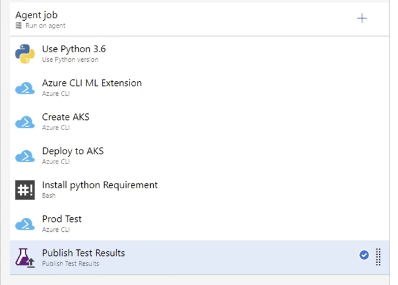

### ✅ CD Pipeline Steps for Model Deployment to Production (Using Ubuntu Agent)

#### 1. Use Ubuntu Agent
- specify the environment to run your pipeline
- Set the pipeline to run on an Ubuntu agent.
- Example: `vmImage: 'ubuntu-latest'`

#### 2. Use Python 3.6
- Set up the Python version to 3.6 for the environment.
- tell agent to use a specific (3.x) version of python

#### 3. Azure CLI ML Extension
- Install the Azure Machine Learning CLI extension using Azure CLI.

#### 4. Create AKS
- Use Azure CLI to create an Azure Kubernetes Service (AKS) cluster.
- This will be used as the production environment.
  ```yaml
            - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az aks create \
                  --resource-group $(resourceGroup) \
                  --name $(aksClusterName) \
                  --node-count $(aksAgentCount) \
                  --node-vm-size $(aksVmSize) \
                  --enable-addons monitoring \
                  --generate-ssh-keys
            displayName: 'Create AKS Cluster with $(aksAgentCount) nodes'
  ```

#### 5. Deploy to AKS
- Deploy the trained model or application to the AKS cluster using Azure Machine Learning deployment commands.
  ```yaml
            - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az ml model deploy \
                  --name $(modelName) \
                  --model-id $(modelName):$(modelVersion) \
                  --ic $(inferenceConfigFile) \
                  --dc $(deploymentConfigFile) \
                  --compute-target $(aksClusterName) \
                  --service-name $(aksServiceName)
            displayName: 'Deploy Model to AKS with service name $(aksServiceName)'
  ```

#### 6. Install Python Requirements
- Install required dependencies from `requirements.txt` using a Bash task.
- Example: `pip install -r requirements.txt`

#### 7. Prod Test
- Run automated production tests by calling the deployed AKS endpoint.
- Validate that the model behaves as expected.

#### 8. Publish Test Results
- Publish and store the test results for monitoring and traceability.
- Useful for test reporting and QA visibility.


## pipeline as code:

```yaml
trigger:
  branches:
    include:
      - main  # Or your release branch
pool:
  vmImage: 'ubuntu-latest'  # Use Ubuntu Agent
variables:
  pythonVersion: '3.6'
  aksAgentCount: 2  # number of worker VMs in your Kubernetes cluster 
  aksVmSize: 'Standard_DS3_v2'  # size of your worker VMs
  resourceGroup: 'my-ml-rg'
  aksClusterName: 'my-aks-cluster'
  aksServiceName: 'production'  # Service name for deployment
  modelName: 'my-prod-model'
  modelVersion: '1'
  inferenceConfigFile: 'inference-config.json'
  deploymentConfigFile: 'aks-deployment-config.json'
  testScript: 'prod_test.py'
  testResultsFile: '**/test-results.xml'
stages:
  - stage: DeployToProduction
    displayName: "Deploy Model to AKS (Production)"
    jobs:
      - job: DeployJob
        displayName: "Deploy Job"
        steps:
          - task: UsePythonVersion@0
            inputs:
              versionSpec: '$(pythonVersion)'
            displayName: 'Use Python $(pythonVersion)'
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az extension add -n azure-cli-ml
            displayName: 'Install Azure CLI ML Extension'
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az aks create \
                  --resource-group $(resourceGroup) \
                  --name $(aksClusterName) \
                  --node-count $(aksAgentCount) \
                  --node-vm-size $(aksVmSize) \
                  --enable-addons monitoring \
                  --generate-ssh-keys
            displayName: 'Create AKS Cluster with $(aksAgentCount) nodes'
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az ml model deploy \
                  --name $(modelName) \
                  --model-id $(modelName):$(modelVersion) \
                  --ic $(inferenceConfigFile) \
                  --dc $(deploymentConfigFile) \
                  --compute-target $(aksClusterName) \
                  --service-name $(aksServiceName)
            displayName: 'Deploy Model to AKS with service name $(aksServiceName)'
          - script: |
              pip install -r requirements.txt
            displayName: 'Install Python Requirements'
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                python $(testScript)
            displayName: 'Run Prod Tests'
          - task: PublishTestResults@2
            inputs:
              testResultsFormat: 'JUnit'
              testResultsFiles: '$(testResultsFile)'
              failTaskOnFailedTests: true
            displayName: 'Publish Test Results'
```

### Q. what is the size for master nodes?

In AKS, the master nodes (control plane) are fully managed by Microsoft. This means:

- You don't specify the size of master nodes
- You don't directly control how many master nodes exist
- You don't pay separately for master nodes - they're included in the AKS service
- Microsoft handles the scaling, maintenance, and availability of the control plane

### Q. what are Key Differences between Creating AKS vs. Deploying to AKS?

When working with Azure Kubernetes Service (AKS) in a machine learning pipeline like yours, there are two distinct operations:

#### 1. Creating an AKS Cluster (`az aks create`)
```yaml
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az aks create \
                  --resource-group $(resourceGroup) \
                  --name $(aksClusterName) \
                  --node-count $(aksAgentCount) \
                  --node-vm-size $(aksVmSize) \
                  --enable-addons monitoring \
                  --generate-ssh-keys
            displayName: 'Create AKS Cluster with $(aksAgentCount) nodes'
```



**What it does:**
- Provisions the underlying infrastructure in Azure
- Creates virtual machines based on the specified VM size
- Sets up the Kubernetes control plane 
- Configures the specified number of agent nodes
- Establishes networking, storage, and security components

**Behind the scenes:**
- Azure provisions the master nodes (managed by Microsoft)
- Creates worker nodes as Azure VMs in your subscription
- Sets up virtual networks and subnets
- Configures load balancers
- Initializes Kubernetes components (kubelet, kube-proxy, etc.)
- Establishes Azure monitoring if enabled
- Creates necessary Azure resources like managed identities

This is essentially building the "hosting platform" that will run your containerized applications.

**Q**. how to enable cluster autoscaler?<br>
A. you can modify your inline bash command of the aks create step as following:

```yaml
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az aks create \
                  --resource-group $(resourceGroup) \
                  --name $(aksClusterName) \
                  --node-vm-size $(aksVmSize) \
                  --enable-addons monitoring \
                  --generate-ssh-keys
                  --enable-cluster-autoscaler \
                  --min-count 1 \
                  --max-count 5 \
            displayName: 'Create AKS Cluster with $(aksAgentCount) nodes'
```

#### 2. Deploying a Model to AKS (`az ml model deploy`)

```yaml
          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az ml model deploy \
                  --name $(modelName) \
                  --model-id $(modelName):$(modelVersion) \
                  --ic $(inferenceConfigFile) \
                  --dc $(deploymentConfigFile) \
                  --compute-target $(aksClusterName) \
                  --service-name $(aksServiceName)
            displayName: 'Deploy Model to AKS with service name $(aksServiceName)'
```

`deploymentConfigFile`:
```yaml
computeType: AKS
autoScaler:
    autoscaleEnabled: True
    minReplicas: 1
    maxReplicas: 3
    refreshPeriodInSeconds: 10
    targetUtilization: 70
authEnabled: True
containerResourceRequirements:
    cpu: 1
    memoryInGB: 0.5
appInsightsEnabled: True
scoringTimeoutMs: 1000
maxConcurrentRequestsPerContainer: 2
maxQueueWaitMs: 1000
sslEnabled: False
```


**What it does:**
- Packages your ML model code into container images
- Pushes these images to a container registry
- Creates Kubernetes deployment objects on your existing AKS cluster
- Sets up service endpoints for model inference
- Configures scaling properties based on your deployment configuration

**Behind the scenes:**
- Azure ML builds Docker images with your model and inference code
- Packages dependencies specified in your inference config
- Pushes images to Azure Container Registry
- Creates Kubernetes manifests for deployments, services, etc.
- Applies these manifests to your existing AKS cluster
- Sets up Kubernetes services to expose your model API
- Configures autoscaling based on your deployment settings
- Names the deployment based on your service name parameter

In your pipeline, the `--service-name production` parameter identifies the specific deployment within the AKS cluster - it's a logical name for your specific model service, not for the entire AKS cluster itself.

The relationship is hierarchical: you create the AKS cluster once (the infrastructure), and then you can deploy multiple model services to it, each with their own service name.